In [648]:
import numpy as np
from numpy import ma
import xarray as xr
from glob import glob
from datetime import datetime, timedelta
from scipy import ndimage as ndi
from scipy import interpolate
from dateutil.parser import parse as parse_date
import argparse
from python_toolbox import abi_tools, dataset_tools, opt_flow
import matplotlib.pyplot as plt
import cv2 as cv
plt.rcParams.update({'figure.max_open_warning': 0})

In [697]:
# Getting files (on jasmin)

base_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/RadC/'

start_date = datetime(2018,6,19,16)
end_date = datetime(2018,6,20,4)
doy_start = (start_date - datetime(start_date.year, 1, 1)).days + 1
doy_end = (end_date - datetime(end_date.year, 1, 1)).days + 1

file_names = []
for year in range(start_date.year, end_date.year+1):
    year_str = str(year).zfill(4)
    if start_date.year == end_date.year:
        for doy in range(doy_start, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == start_date.year:
        for doy in range(doy_start, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == end_date.year:
        for doy in range(1, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    else:
        for doy in range(1, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))

# Get all filenames
goes_files = [abi_tools.get_goes_abi_files(f) for f in file_names]
# Filter for start and end date
goes_files = [f for f in goes_files if f[0] >= start_date and f[0] <= end_date and len(f) == 17]

len(goes_files)

143

In [698]:
# Get brightness temperature for channel 8,10,13 and 15
# Upper level water vapour (6.2um)
C8_data = abi_tools.get_abi_ds_from_files([f[8] for f in goes_files])[:,600:900,1300:1600]
# Lower level water vapour (7.3um)
C10_data = abi_tools.get_abi_ds_from_files([f[10] for f in goes_files])[:,600:900,1300:1600]
# Clean IR LW window channel(10.8um)
C13_data = abi_tools.get_abi_ds_from_files([f[13] for f in goes_files])[:,600:900,1300:1600]
# Dirty IR LW window channel(12.0um)
C15_data = abi_tools.get_abi_ds_from_files([f[15] for f in goes_files])[:,600:900,1300:1600]

dataset_tools.match_coords([C13_data,C10_data,C8_data,C15_data])


In [699]:
C13_data = C13_data.compute()

In [700]:
# water vapour and split window differences
wvd = (C8_data - C10_data).compute()
swd = (C13_data - C15_data).compute()


Text(0.5,1,'Combined difference')

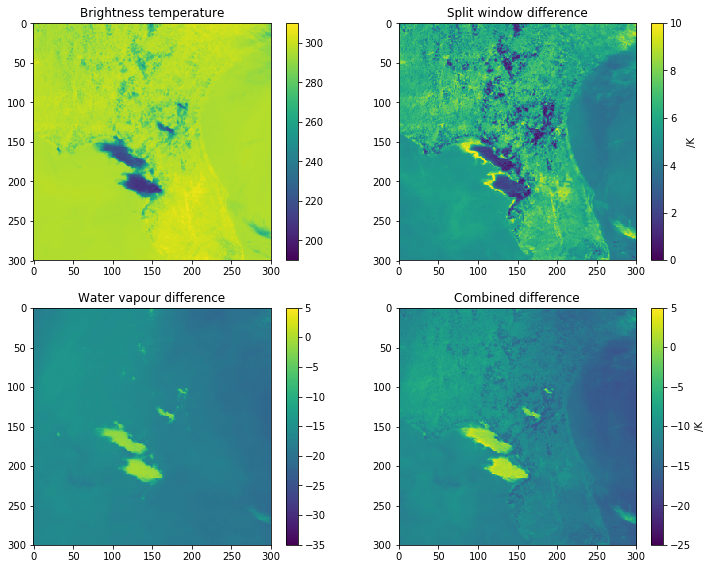

In [701]:
fig, ax = plt.subplots(2,2,figsize=(12,9.6))
bt = ax[0,0].imshow(C13_data[24], vmin=190,vmax=310)
plt.colorbar(bt, ax=ax[0,0])
ax[0,0].set_title('Brightness temperature')

wv = ax[1,0].imshow(wvd[24], vmin=-35,vmax=5)
plt.colorbar(wv, ax=ax[1,0])
ax[1,0].set_title('Water vapour difference')

sw = ax[0,1].imshow(swd[24], vmin=0,vmax=10)
plt.colorbar(sw, label='/K', ax=ax[0,1])
ax[0,1].set_title('Split window difference')

sw = ax[1,1].imshow(swd[24]+wvd[24], vmin=-25,vmax=5)
plt.colorbar(sw, label='/K', ax=ax[1,1])
ax[1,1].set_title('Combined difference')


Note that the split window temperatures are low in the middle of deep clouds, but high at the edges. I am using this to distinguish between the core and anvil parts of DCCs

In [702]:
field_flow = opt_flow.get_flow_func(C13_data, replace_missing=True,
                                    pyr_scale=0.5, levels=6, winsize=31, 
                                    iterations=5, poly_n=7, poly_sigma=1.5, 
                                    flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)

Flow func can now be indexed and the individual vectors accessed separately:

In [703]:
field_flow[0,:10](1)[0].shape

(10, 300)

In [704]:
field_flow.flow_x_for[0]

masked_array(
  data=[[4.282625377527438e-05, 6.48265122435987e-05,
         8.935392543207854e-05, ..., -0.00032858221675269306,
         -0.00024306403065565974, -0.00016943119408097118],
        [7.723682938376442e-05, 0.00011802242806879804,
         0.00016472648712806404, ..., -0.0005949213518761098,
         -0.0004319121944718063, -0.0002966407919302583],
        [0.00012827284808736295, 0.00019710251945070922,
         0.0002774142485577613, ..., -0.0009953639237210155,
         -0.0007119686342775822, -0.00048309663543477654],
        ...,
        [-1.8371520127402619e-07, -3.965839141528704e-07,
         -7.827975423424505e-07, ..., -0.07697701454162598,
         -0.04967670515179634, -0.030172931030392647],
        [-1.0713440445897504e-07, -2.3483256939016428e-07,
         -4.6893646299395186e-07, ..., -0.034096069633960724,
         -0.022224167361855507, -0.013653910718858242],
        [-5.8510039480097475e-08, -1.3057029946139664e-07,
         -2.642277081577049e-07, ..

Text(0.5,1,'Y flow vector')

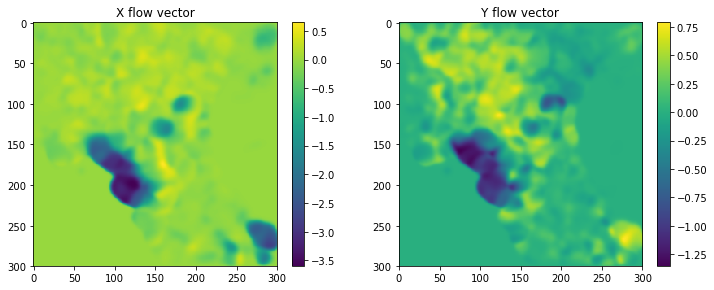

In [705]:
fig, ax = plt.subplots(1,2,figsize=(12,4.5))
x_vec = ax[0].imshow(field_flow(1)[0][24])
plt.colorbar(x_vec, ax=ax[0])
ax[0].set_title('X flow vector')

y_vec = ax[1].imshow(field_flow(1)[1][24])
plt.colorbar(y_vec, ax=ax[1])
ax[1].set_title('Y flow vector')



## Semi-lagrangian BT cooling

In [706]:
# this gets a 3*arr.shape array of the field interpolated by one frame forwards and backwards
bt_stack = opt_flow.get_flow_stack(C13_data, field_flow).data


In [707]:
dx, dy = abi_tools.get_abi_pixel_lengths(C13_data)

In [708]:
# delta t, and also the spatial second derivative to find peaks in the brightness temperature
bt_dt = np.gradient(bt_stack, axis=0)[1]
bt_grad = (np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=1), axis=1)/dy**2,
                (0,1.5,1.5)), 0), 1) 
           * np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)/dx**2,
                (0,1.5,1.5)), 0), 1))**0.5

# gaussian filter applied to grad bt to reduce noise

Text(0.5,1,'grad BT')

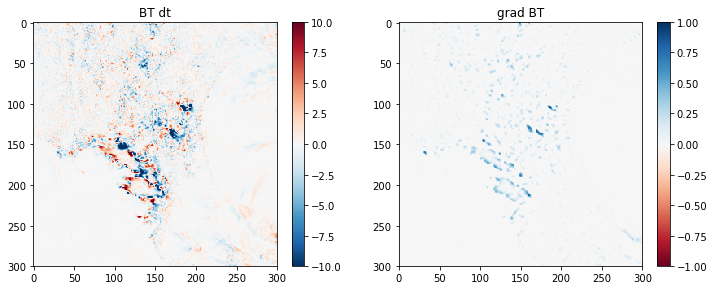

In [709]:
fig, ax = plt.subplots(1,2,figsize=(12,4.5))
btdt = ax[0].imshow(bt_dt[24],vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar(btdt, ax=ax[0])
ax[0].set_title('BT dt')

gradbt = ax[1].imshow(bt_grad[24],vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar(gradbt, ax=ax[1])
ax[1].set_title('grad BT')


By multiplying these fields we can get a metric for how much a peak in the BT field (positive grad) is growing (negative BTdt)

In [710]:
bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0) * bt_grad, 0),10)


In [711]:
#dilate the field in a semi-lagrangian way
bt_growth = opt_flow.flow_convolve_nearest(bt_growth, field_flow, 
                                           structure=ndi.generate_binary_structure(3,2),
                                           function=np.nanmax)


/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py:315: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


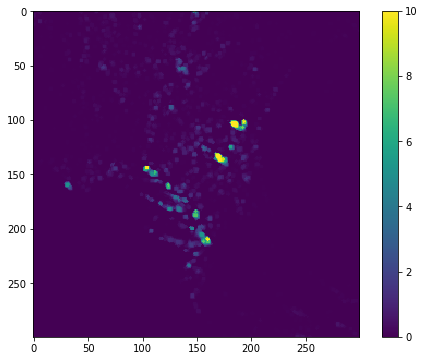

In [712]:
plt.figure(figsize=(8,6))
plt.imshow(bt_growth[24])
plt.colorbar()

Text(0.5,1,'BT growth metric')

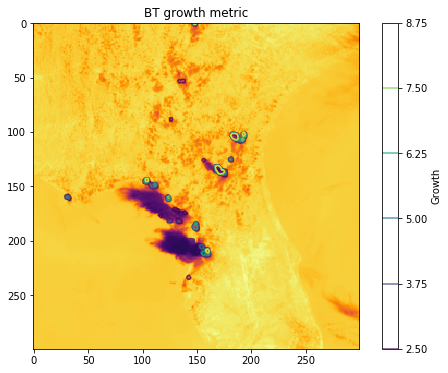

In [713]:
plt.figure(figsize=(8,6))
plt.imshow(C13_data[24],cmap='inferno',vmax=310,vmin=190)
plt.contour(bt_growth[24],np.arange(2.5,11.25,1.25), alpha=0.75)
# plt.gca().invert_yaxis()
plt.colorbar(label='Growth')
plt.title('BT growth metric')

I've found that 2.5 is a good value for this, it's approximately equal to a peak cooling of 0.5K/minute

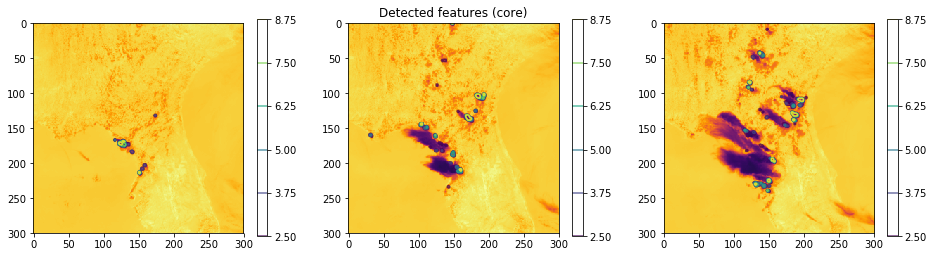

In [714]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],cmap='inferno',vmin=190,vmax=310)
c0 = ax[0].contour(bt_growth[12],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c0, ax=ax[0])

m1 = ax[1].imshow(C13_data[24],cmap='inferno',vmin=190,vmax=310)
c1 = ax[1].contour(bt_growth[24],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('Detected features (core)')

m2 = ax[2].imshow(C13_data[36],cmap='inferno',vmin=190,vmax=310)
c2 = ax[2].contour(bt_growth[36],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c2, ax=ax[2])


## Semi-lagrangian watershedding

In [715]:
upper_thresh = -5
lower_thresh = -15
markers = wvd>upper_thresh
markers = np.logical_and(markers, bt_growth>2.5).to_masked_array()
mask = (wvd<lower_thresh).to_masked_array()
for i in range(np.minimum(3, (mask.shape[0]-1)//2)):
    # Semi-lagrangian erosion of the mask by up to three steps
    mask = opt_flow.flow_convolve_nearest(mask, field_flow, 
                                          structure=ndi.generate_binary_structure(3,2),
                                          function=np.nanmin)

/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


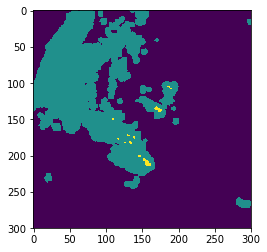

In [716]:
plt.imshow((markers.astype(int)-mask.astype(int))[24])

Markers in yellow. Mask in dark blue. Unfilled regions are in teal

In [717]:
# Sobel edge detection for watershedding. Combine WVD, SWD and growth to find regions
inner_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve( 
                                                  opt_flow.get_flow_stack((wvd-swd+bt_growth-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


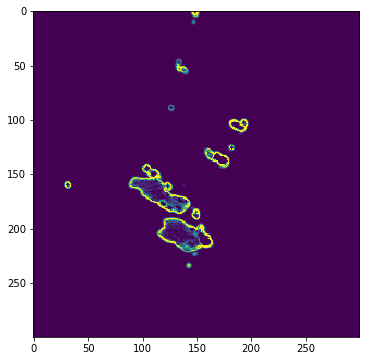

In [718]:
plt.figure(figsize=(8,6))
plt.imshow(inner_edges[24],vmin=0,vmax=50)

In [719]:
# Watershed
features = opt_flow.flow_network_watershed(inner_edges, markers, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 4352441
Convergence
Iteration: 1
Pixels converged 9465841
Convergence
Iteration: 2
Pixels converged 9920766
Convergence
Iteration: 3
Pixels converged 10365658
Convergence
Iteration: 4
Pixels converged 10910153
Convergence
Iteration: 5
Pixels converged 11553731
Convergence
Iteration: 6
Pixels converged 12285166
Convergence
Iteration: 7
Pixels converged 12841892
Convergence
Iteration: 8
Pixels converged 12870000
All pixels converged
Filling basins
Joining labels
Max label: 35294
max_markers: 1
Iteration: 1
Remaining labels: 6802
Iteration: 2
Remaining labels: 1379
Iteration: 3
Remaining labels: 287
Iteration: 4
Remaining labels: 50
Iteration: 5
Remaining labels: 13
Iteration: 6
Remaining labels: 6
Iteration: 7
Remaining labels: 2


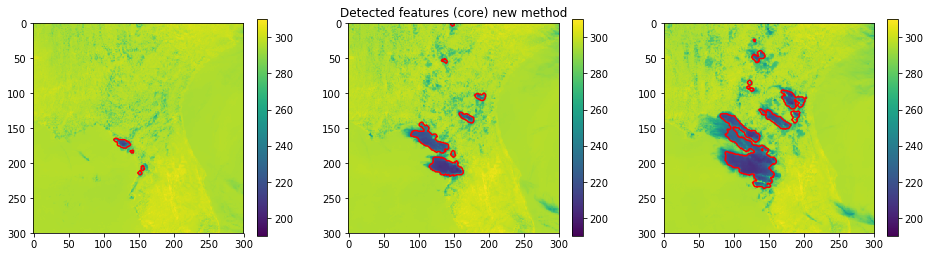

In [720]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (core) new method')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(features[36],[0.5],colors=['red'])


Repeat for outer regions

In [ ]:

outer_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve(
                                                  opt_flow.get_flow_stack((wvd+swd+bt_growth-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(outer_edges[24],vmin=0,vmax=50)

In [723]:
# Watershed
outer = opt_flow.flow_network_watershed(outer_edges, features, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Iteration: 1
Remaining labels: 17234
Iteration: 2
Remaining labels: 3928
Iteration: 3
Remaining labels: 873
Iteration: 4
Remaining labels: 173
Iteration: 5
Remaining labels: 26
Iteration: 6
Remaining labels: 2


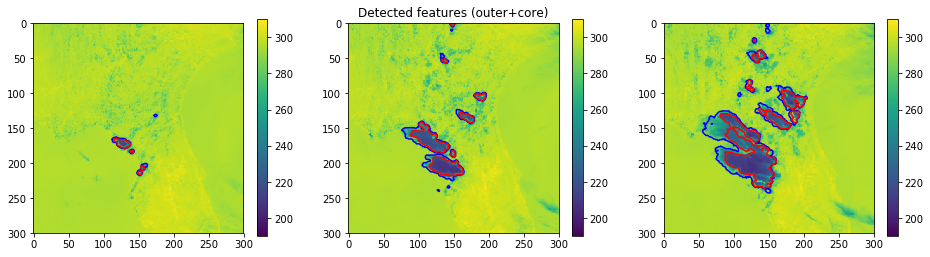

In [724]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(outer[12],[0.5],colors=['blue'])
ax[0].contour(features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(outer[24],[0.5],colors=['blue'])
ax[1].contour(features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(outer[36],[0.5],colors=['blue'])
ax[2].contour(features[36],[0.5],colors=['red'])


The 'outer' region seems to pick up the extent of the anvil outflow fairly well

Picking out the mean brightness temperature of each region at each step and plotting one. Looks reasonable

In [725]:
inner_labels = ndi.label(features)[0]
bt_labels = [[np.nanmean(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

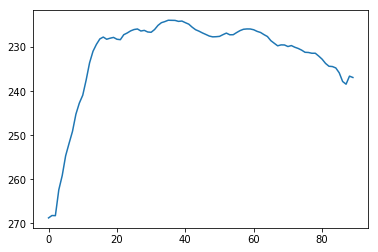

In [726]:
plt.plot(bt_labels[0])
plt.gca().invert_yaxis()

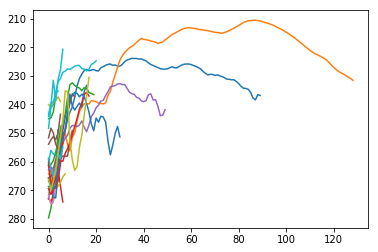

In [727]:
for i in range(len(bt_labels)):
    plt.plot(bt_labels[i])
plt.gca().invert_yaxis()

In [728]:
outer_labels = ndi.label(outer)[0]
bt_labels2 = [[np.nanmean(C13_data[j].data.ravel()[(outer_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(outer_labels[j]==i)] 
             for i in np.arange(1,outer_labels.max()+1)]

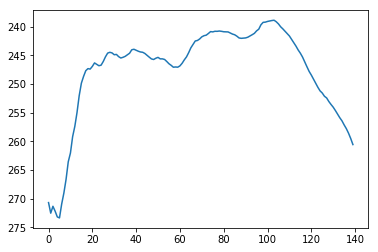

In [729]:
plt.plot(bt_labels2[1])
plt.gca().invert_yaxis()

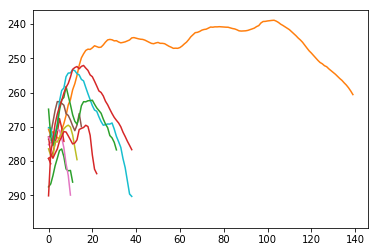

In [730]:
for i in range(len(bt_labels2)):
    plt.plot(bt_labels2[i])
plt.gca().invert_yaxis()

In [731]:
inner_labels = ndi.label(features)[0]
max_labels = [[np.nanmin(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

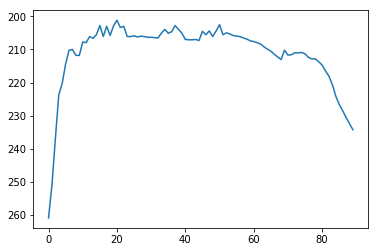

In [732]:
plt.plot(max_labels[0])
plt.gca().invert_yaxis()

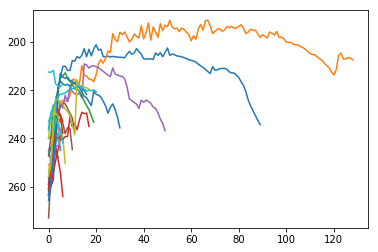

In [747]:
for i in range(len(max_labels)):
    plt.plot(max_labels[i])
plt.gca().invert_yaxis()

In [733]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmax(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

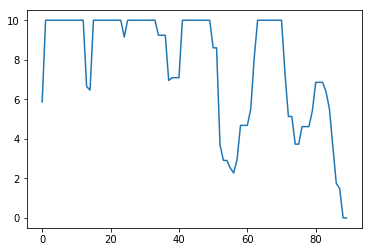

In [734]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

In [735]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmean(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

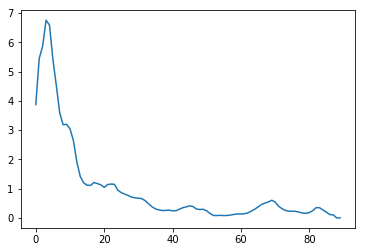

In [736]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

Comparison with GLM data

In [737]:
glm_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/17[01]/*'
glm_files = glob(glm_path+'/OR_GLM-L2-LCFA_*.nc')
glm_files.sort()
glm_dates = [abi_tools.get_abi_date_from_filename(f) for f in glm_files]
glm_dates_array = np.array(glm_dates)

In [738]:
glm_files[0]

'/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/170/00/OR_GLM-L2-LCFA_G16_s20181700000000_e20181700000200_c20181700000226.nc'

In [739]:
p = abi_tools.get_abi_proj(C13_data[0])
height=C13_data[0].goes_imager_projection.perspective_point_height

In [740]:
# Get lightning event and flash locations
event_x = []
event_y = []
flash_x = []
flash_y = []
for abi_file in goes_files:
#     abi_file = goes_files[f_ind]
    wh_dates = np.all([glm_dates_array>=abi_file[0], glm_dates_array<(abi_file[0]+timedelta(minutes=5))], axis=0)
    matched_glm_files = np.array(glm_files)[wh_dates]
    t_event_x = []
    t_event_y = []
    t_flash_x = []
    t_flash_y = []
    for glm_file in matched_glm_files:
        with xr.open_dataset(glm_file) as glm_ds:
            temp_x, temp_y = (output/height for output in p(glm_ds.event_lon.data, glm_ds.event_lat.data))
            t_event_x.append(temp_x)
            t_event_y.append(temp_y)
            temp_x, temp_y = (output/height for output in p(glm_ds.flash_lon.data, glm_ds.flash_lat.data))
            t_flash_x.append(temp_x)
            t_flash_y.append(temp_y)

    event_x.append(np.concatenate(t_event_x))
    event_y.append(np.concatenate(t_event_y))
    flash_x.append(np.concatenate(t_flash_x))
    flash_y.append(np.concatenate(t_flash_y))

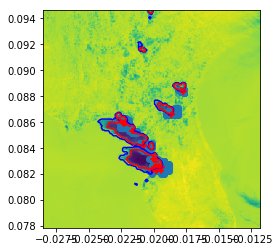

In [741]:
plt.imshow(C13_data[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
plt.contour(C13_data[0].x, C13_data[0].y, outer[f_ind],[0.5],colors=['blue'])
plt.contour(C13_data[0].x, C13_data[0].y, features[f_ind],[0.5],colors=['red'])

wh = np.all([event_x[f_ind]>=C13_data[0].x[0].item(),
             event_x[f_ind]<=C13_data[0].x[-1].item(),
             event_y[f_ind]>=C13_data[0].y[-1].item(),
             event_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(event_x[f_ind][wh], event_y[f_ind][wh])
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [742]:
outer_dist = ndi.distance_transform_edt(np.logical_not(outer))

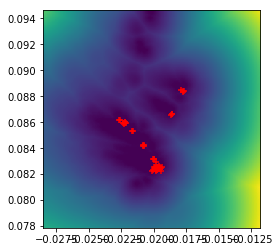

In [743]:
plt.imshow(outer_dist[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
# plt.colorbar()
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [744]:
dist_test = interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[f_ind][::-1],
                                np.stack([flash_y[f_ind], flash_x[f_ind]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan)

In [745]:
outer_dists = []
for i in range(outer_dist.shape[0]):
    outer_dists.append(interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[i][::-1],
                                np.stack([flash_y[i], flash_x[i]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan))
outer_dists = np.concatenate(outer_dists)
outer_dists = ma.array(outer_dists, mask=np.isnan(outer_dists))

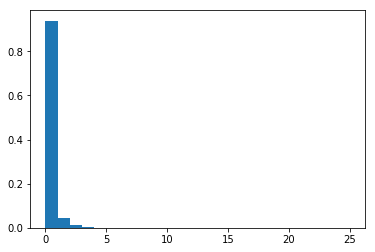

In [746]:
h = plt.hist(outer_dists, bins=np.arange(0,26), density=True,stacked=True)